DATASET OVERVIEW
Samples: 1866
Features: 13
Time steps (records): 13632
Size: 2522.93 MB

FEATURE STATISTICS (across all samples & locations)
 0. Latitude     | min:      18.65 | max:      53.47 | mean:      33.38
 1. Longitude    | min:      75.25 | max:     133.99 | mean:     112.43
 2. Altitude     | min:     -47.20 | max:    4613.00 | mean:     605.86
 3. Air pressure | min:     564.90 | max:    1050.00 | mean:     948.94
 4. Air Temperature | min:     -17.50 | max:      47.20 | mean:      14.42
 5. Maximum Temperature | min:     -16.85 | max:      48.10 | mean:      14.91
 6. Minimum Temperature | min:     -17.75 | max:      46.90 | mean:      13.94
 7. Relative humidity | min:       0.00 | max:     100.00 | mean:      67.57
 8. Precipitation in 3h | min:      -1.00 | max:    1049.70 | mean:       0.34
 9. Wind direction | min:       0.00 | max:     360.00 | mean:     174.47
10. Wind speed   | min:       0.00 | max:      37.70 | mean:       2.08
11. Maximum wind direction | min:  

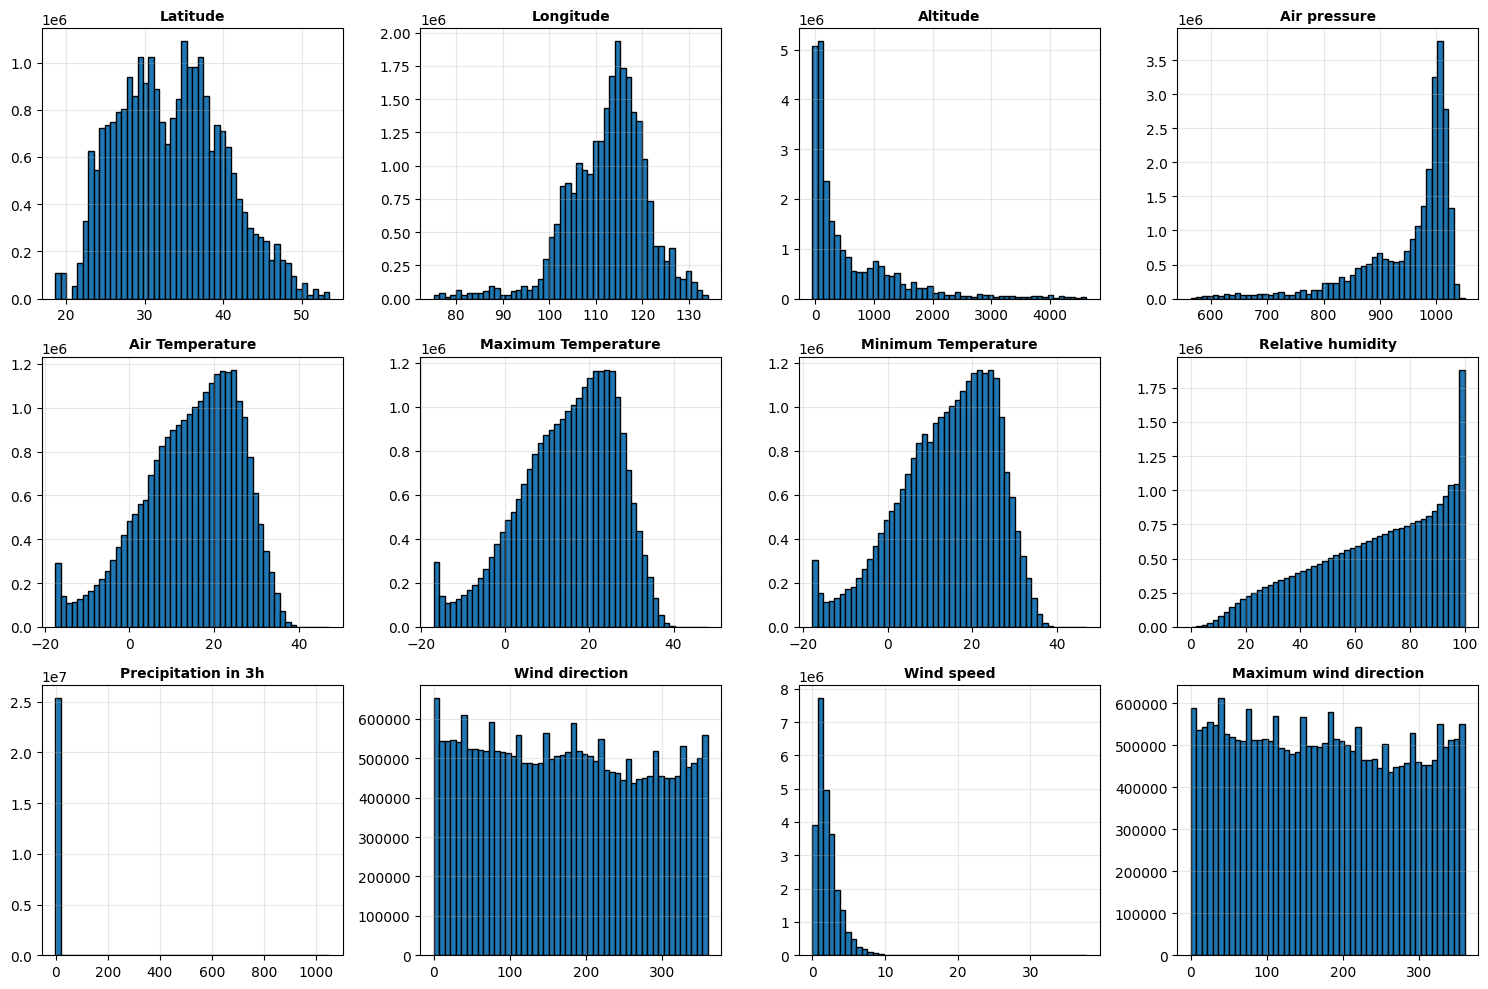

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.load(r"weather2k.npy", allow_pickle=True)

# Feature names
features = ['Latitude', 'Longitude', 'Altitude', 'Air pressure', 'Air Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Relative humidity', 'Precipitation in 3h', 
            'Wind direction', 'Wind speed', 'Maximum wind direction', 'Maximum wind speed']

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Samples: {data.shape[0]}")
print(f"Features: {data.shape[1]}")
print(f"Time steps (records): {data.shape[2]}")
print(f"Size: {data.nbytes / (1024**2):.2f} MB\n")

print("="*60)
print("FEATURE STATISTICS (across all samples & locations)")
print("="*60)
for i, fname in enumerate(features[:data.shape[1]]):
    feature_data = data[:, i, :]
    print(f"{i:2d}. {fname:12s} | min: {feature_data.min():10.2f} | "
          f"max: {feature_data.max():10.2f} | mean: {feature_data.mean():10.2f}")

print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)
print(f"NaN values: {np.isnan(data).sum()}")
print(f"Inf values: {np.isinf(data).sum()}")
print(f"Zero values: {(data == 0).sum()} ({(data == 0).sum() / data.size * 100:.2f}%)")

print("\n" + "="*60)
print("SAMPLE ANALYSIS")
print("="*60)
print(f"Sample 0 temp range: {data[0, 4, :].min():.1f}°C to {data[0, 4, :].max():.1f}°C")
print(f"Sample 0 humidity range: {data[0, 7, :].min():.1f}% to {data[0, 7, :].max():.1f}%")

# Visualize feature distributions
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(12, data.shape[1])):
    feature_data = data[:, i, :].flatten()
    axes[i].hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black')
    axes[i].set_title(f"{features[i]}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weather_features_distribution.png', dpi=100)
print("\n✓ Saved feature distributions to 'weather_features_distribution.png'")

# Correlation analysis
print("\n" + "="*60)
print("FEATURE CORRELATIONS (sample 0)")
print("="*60)
sample_data = data[0, :, :].T  # Transpose to (locations, features)
corr_matrix = np.corrcoef(sample_data.T)

# Show strongest correlations
for i in range(min(5, data.shape[1])):
    for j in range(i+1, min(5, data.shape[1])):
        print(f"{features[i]:6s} vs {features[j]:6s}: {corr_matrix[i, j]:6.3f}")

print("\n" + "="*60)
print("SPATIAL ANALYSIS")
print("="*60)
print(f"Unique Latitude values: {len(np.unique(data[:, 0, :]))}")
print(f"Unique Longitude values: {len(np.unique(data[:, 1, :]))}")
print(f"Altitude range: {data[:, 2, :].min():.0f}m to {data[:, 2, :].max():.0f}m")

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
# Check the original table more carefully
print(f"Total features in data: {data.shape[1]}")
print("\nChecking all features:")

for i in range(data.shape[1]):
    print(f"Index {i}: range [{data[:, i, :].min():.2f}, {data[:, i, :].max():.2f}]")

# Specifically check if 5 and 6 are both temperature-related
print("\n--- Temperature Analysis ---")
print(f"Index 5: {data[:, 5, :].min():.2f} to {data[:, 5, :].max():.2f}")
print(f"Index 6: {data[:, 6, :].min():.2f} to {data[:, 6, :].max():.2f}")

# Check if one is consistently higher (max) than the other (min)
sample_station = 0
sample_time = 100
print(f"\nSample comparison at station {sample_station}, time {sample_time}:")
print(f"Index 5: {data[sample_station, 5, sample_time]:.2f}")
print(f"Index 6: {data[sample_station, 6, sample_time]:.2f}")

Total features in data: 13

Checking all features:
Index 0: range [18.65, 53.47]
Index 1: range [75.25, 133.99]
Index 2: range [-47.20, 4613.00]
Index 3: range [564.90, 1050.00]
Index 4: range [-17.50, 47.20]
Index 5: range [-16.85, 48.10]
Index 6: range [-17.75, 46.90]
Index 7: range [0.00, 100.00]
Index 8: range [-1.00, 1049.70]
Index 9: range [0.00, 360.00]
Index 10: range [0.00, 37.70]
Index 11: range [0.00, 360.00]
Index 12: range [0.00, 48.90]

--- Temperature Analysis ---
Index 5: -16.85 to 48.10
Index 6: -17.75 to 46.90

Sample comparison at station 0, time 100:
Index 5: -14.90
Index 6: -15.30


In [4]:
# apply log transform to the precipitation
# Index 8 is precipitation column
PRECIP_IDX = 8

# Add small constant to avoid log(0), then log transform, the log transform would work because the column data is right-skewed data
data[:, PRECIP_IDX, :] = np.log1p(data[:, PRECIP_IDX, :])  # log1p = log(1 + x)
print(f"Applied log transform to precipitation")

# Wind direction is circular - convert to sin/cos
# Indices 9 and 11 are wind directions
WD_INDICES = [9, 11]

for wd_idx in WD_INDICES:
    # Convert degrees to radians, then to sin/cos
    rad = np.deg2rad(data[:, wd_idx, :])
    sin_component = np.sin(rad)
    cos_component = np.cos(rad)
    
    # Replace original with sin, append cos as new feature
    data[:, wd_idx, :] = sin_component
    # Add cos component as new feature
    cos_feature = cos_component[np.newaxis, :, :]  # Add feature dimension
    data = np.concatenate([data, cos_feature.transpose(1, 0, 2)], axis=1)

print(f"Converted wind directions to sin/cos. New shape: {data.shape}")

/tmp/ipykernel_5607/2054478675.py:6: RuntimeWarning: divide by zero encountered in log1p
  data[:, PRECIP_IDX, :] = np.log1p(data[:, PRECIP_IDX, :])  # log1p = log(1 + x)


Applied log transform to precipitation
Converted wind directions to sin/cos. New shape: (1866, 15, 13632)


In [5]:
# Original feature names
features = [
    "Latitude", "Longitude", "Altitude", "Air pressure", "Air Temperature",
    "Maximum Temperature", "Minimum Temperature", "Relative humidity",
    "Precipitation", "Wind direction", "Wind speed", "Max wind dir", "Max wind speed"
]

# Add cos features for wind directions
for idx in WD_INDICES:
    features.append(f"{features[idx]}_cos")

print("New feature names:")
# Compute min, max, mean for all features
print("\nFEATURE STATS (with new cos features)")
for i, f in enumerate(features):
    feature_data = data[:, i, :].flatten()
    print(f"{i:2d}. {f:25s} | min: {feature_data.min():10.2f} | max: {feature_data.max():10.2f} | mean: {feature_data.mean():10.2f}")

New feature names:

FEATURE STATS (with new cos features)
 0. Latitude                  | min:      18.65 | max:      53.47 | mean:      33.38
 1. Longitude                 | min:      75.25 | max:     133.99 | mean:     112.43
 2. Altitude                  | min:     -47.20 | max:    4613.00 | mean:     605.86
 3. Air pressure              | min:     564.90 | max:    1050.00 | mean:     948.94
 4. Air Temperature           | min:     -17.50 | max:      47.20 | mean:      14.42
 5. Maximum Temperature       | min:     -16.85 | max:      48.10 | mean:      14.91
 6. Minimum Temperature       | min:     -17.75 | max:      46.90 | mean:      13.94
 7. Relative humidity         | min:       0.00 | max:     100.00 | mean:      67.57
 8. Precipitation             | min:       -inf | max:       6.96 | mean:       -inf
 9. Wind direction            | min:      -1.00 | max:       1.00 | mean:       0.03
10. Wind speed                | min:       0.00 | max:      37.70 | mean:       2.08
11. Max

In [6]:
print(f"Shape: {data.shape}")

# Check for NaN/Inf values
nan_count = np.isnan(data).sum()
inf_count = np.isinf(data).sum()
print(f"NaN values: {nan_count}, Inf values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    for i in range(data.shape[1]):
        feature = data[:, i, :]
        # Calculate median only on finite values
        valid_mask = np.isfinite(feature)
        if valid_mask.any():
            median_val = np.median(feature[valid_mask])
        else:
            median_val = 0.0
        
        # Replace NaN and Inf with median
        data[:, i, :] = np.where(np.isfinite(feature), feature, median_val)
    
    print("Replaced NaN/Inf with median values")
    print(f"After fix - NaN: {np.isnan(data).sum()}, Inf: {np.isinf(data).sum()}")

Shape: (1866, 15, 13632)
NaN values: 0, Inf values: 3645
Replaced NaN/Inf with median values
After fix - NaN: 0, Inf: 0


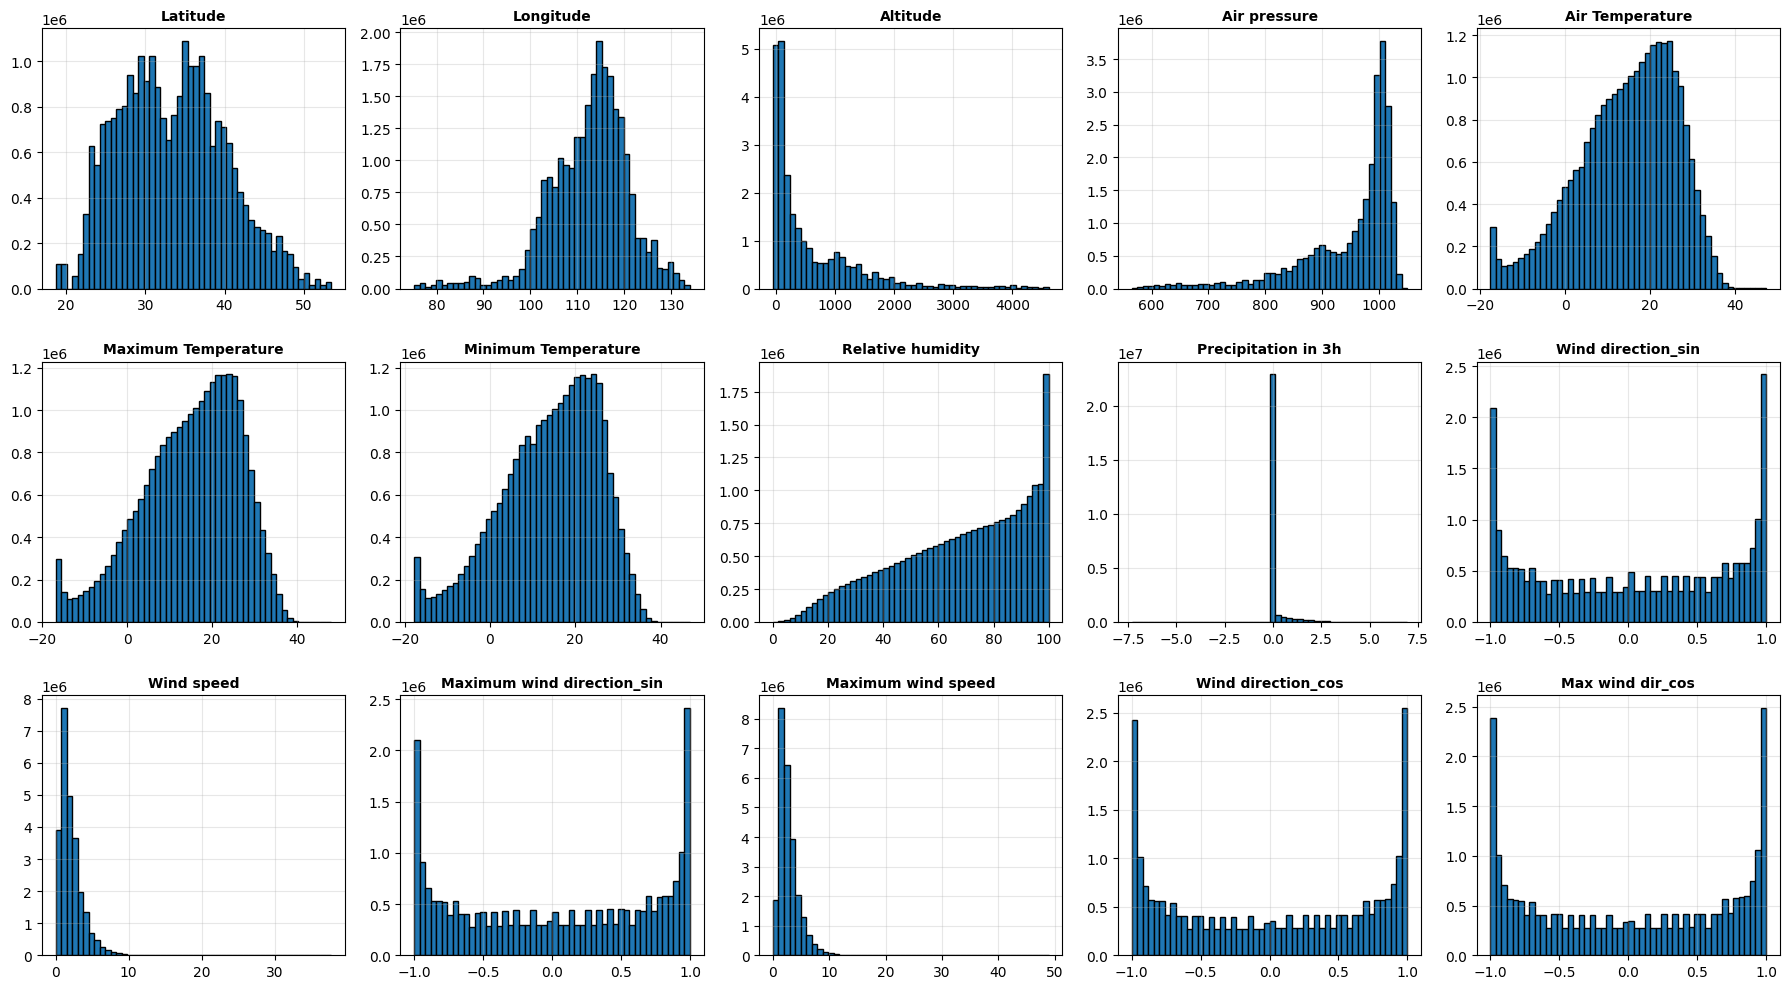

In [7]:
# Feature names
features = ['Latitude', 'Longitude', 'Altitude', 'Air pressure', 'Air Temperature', 
            'Maximum Temperature', 'Minimum Temperature', 'Relative humidity', 
            'Precipitation in 3h', 'Wind direction_sin', 'Wind speed', 
            'Maximum wind direction_sin', 'Maximum wind speed', 'Wind direction_cos', 'Max wind dir_cos']

# Visualize feature distributions
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
axes = axes.flatten()

for i in range(data.shape[1]):  # All 15 features
    feature_data = data[:, i, :].flatten()
    axes[i].hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black')
    axes[i].set_title(f"{features[i]}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weather_features_distribution_after_preprocessing.png', dpi=100)
plt.show()

In [8]:
# Split by stations (samples dimension)
n_stations = data.shape[0]
n_train = int(0.7 * n_stations)
n_val = int(0.15 * n_stations)

train_data = data[:n_train]      # 70%
val_data = data[n_train:n_train+n_val]  # 15%
test_data = data[n_train+n_val:]  # 15%

print(f"Train stations: {train_data.shape[0]}")
print(f"Val stations: {val_data.shape[0]}")
print(f"Test stations: {test_data.shape[0]}")

# Normalize using train statistics
# Reshape to (samples*timesteps, features) for fitting scaler
train_flat = train_data.transpose(0, 2, 1).reshape(-1, train_data.shape[1])

scaler = StandardScaler()
scaler.fit(train_flat)

def normalize_data(data, scaler):
    """Normalize data using fitted scaler"""
    n_stations, n_features, n_timesteps = data.shape
    data_transposed = data.transpose(0, 2, 1)  # (stations, timesteps, features)
    data_flat = data_transposed.reshape(-1, n_features)
    data_normalized = scaler.transform(data_flat)
    data_normalized = data_normalized.reshape(n_stations, n_timesteps, n_features)
    return data_normalized.transpose(0, 2, 1)  # Back to (stations, features, timesteps)

train_norm = normalize_data(train_data, scaler)
val_norm = normalize_data(val_data, scaler)
test_norm = normalize_data(test_data, scaler)

print("Data normalized")

Train stations: 1306
Val stations: 279
Test stations: 281
Data normalized


In [9]:
class WeatherDataset(Dataset):
    def __init__(self, data, seq_len, pred_horizon, slide_step, target_idxs):
        """
        Args:
            data: (n_stations, n_features, n_timesteps)
            seq_len: input sequence length
            pred_horizon: number of future timesteps to predict
            slide_step: sliding window step size
            target_idxs: index of target feature (mxt/mnt)
        """
        self.data = data
        self.seq_len = seq_len
        self.pred_horizon = pred_horizon
        self.slide_step = slide_step
        self.target_idxs = target_idxs
        
        # Generate all valid window indices
        self.samples = []
        n_stations, n_features, n_timesteps = data.shape
        
        for station_idx in range(n_stations):
            for start_idx in range(0, n_timesteps - seq_len - pred_horizon + 1, slide_step):
                end_idx = start_idx + seq_len
                self.samples.append((station_idx, start_idx, end_idx))
        
        print(f"Created {len(self.samples)} windows")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        station_idx, start_idx, end_idx = self.samples[idx]
        
        # Input: all features for seq_len timesteps
        X = self.data[station_idx, :, start_idx:end_idx]  # (n_features, seq_len)
        
        # Target: only mxt/mnt for next pred_horizon timesteps
        y = self.data[station_idx, self.target_idxs, end_idx:end_idx + self.pred_horizon]
        
        return torch.FloatTensor(X), torch.FloatTensor(y)

In [10]:
SEQ_LEN = 168      # 1 week of 3-hour data
PRED_HORIZON = 8   # Predict next 8 timesteps (24 hours)
SLIDE_STEP = 24    # Slide by 24 steps (72 hours)
TARGET_IDXS = [4, 5, 6, 8]

In [11]:
train_dataset = WeatherDataset(train_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)
val_dataset = WeatherDataset(val_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)
test_dataset = WeatherDataset(test_norm, SEQ_LEN, PRED_HORIZON, SLIDE_STEP, TARGET_IDXS)

Created 732666 windows
Created 156519 windows
Created 157641 windows


In [12]:
# =========================================================
# Model configuration parameters
# =========================================================

num_features = train_norm.shape[1]
num_targets = len(TARGET_IDXS)
horizon = PRED_HORIZON


In [13]:
# =========================================================
# Bi-Directional LSTM model definition
# =========================================================
class BiLSTMModel(nn.Module):
    def __init__(self, num_features, hidden_size=64):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True
        )
        
        self.fc = nn.Linear(hidden_size * 2, num_targets * horizon)

    def forward(self, x):
        # x: (batch, features, seq_len)
        x = x.permute(0, 2, 1)   # (batch, seq_len, features)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(out.size(0), num_targets, horizon)


In [14]:
# =========================================================
# Model initialisation and training setup
# =========================================================


model = BiLSTMModel(num_features).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [15]:
# =========================================================
# Data loaders for training and validation
# =========================================================

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)



In [16]:
train_losses = []
val_losses = []


In [17]:
# Training and validation loop

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    train_loss /= len(train_loader)

    # ---------- Validation ----------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            val_loss += loss.item()

    # Average validation loss for this epoch
    val_loss /= len(val_loader)

    # 🔹 SAVE LOSSES HERE (THIS IS THE PLACE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )


Epoch [1/10] | Train Loss: 0.2610 | Val Loss: 0.4184
Epoch [2/10] | Train Loss: 0.2504 | Val Loss: 0.4074
Epoch [3/10] | Train Loss: 0.2452 | Val Loss: 0.4043
Epoch [4/10] | Train Loss: 0.2411 | Val Loss: 0.4084
Epoch [5/10] | Train Loss: 0.2380 | Val Loss: 0.4078
Epoch [6/10] | Train Loss: 0.2352 | Val Loss: 0.4078
Epoch [7/10] | Train Loss: 0.2330 | Val Loss: 0.4074
Epoch [8/10] | Train Loss: 0.2308 | Val Loss: 0.4135
Epoch [9/10] | Train Loss: 0.2293 | Val Loss: 0.4132
Epoch [10/10] | Train Loss: 0.2273 | Val Loss: 0.4146


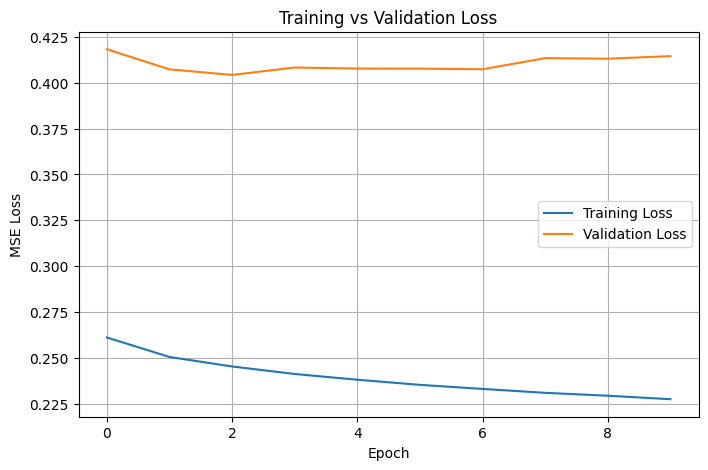

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# =========================================================
# Model evaluation on the test set
# =========================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X, y in DataLoader(test_dataset, batch_size=64):
        X = X.to(device)
        preds = model(X).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# flatten for metrics
preds_flat = all_preds.reshape(-1)
targets_flat = all_targets.reshape(-1)

mse = mean_squared_error(targets_flat, preds_flat)
rmse = np.sqrt(mse)

mae  = mean_absolute_error(targets_flat, preds_flat)
r2   = r2_score(targets_flat, preds_flat)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")



RMSE: 0.7136
MAE : 0.2970
R²  : 0.4144


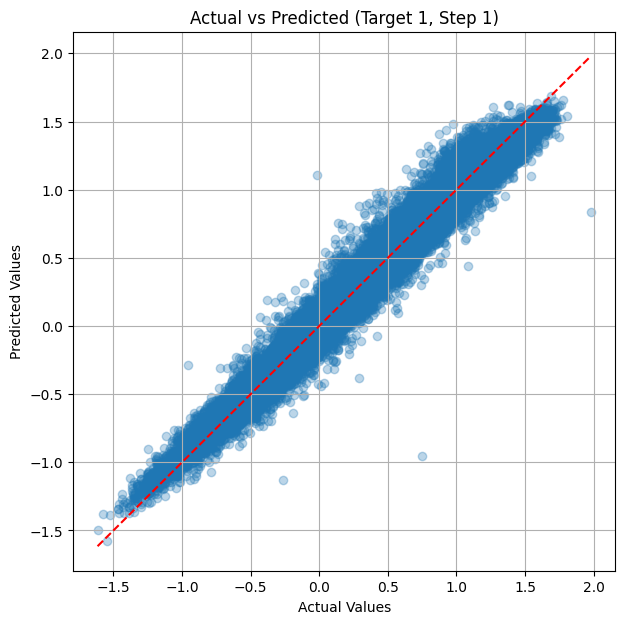

In [20]:
# Select first target and first prediction step
true_vals = all_targets[:, 0, 0]
pred_vals = all_preds[:, 0, 0]

plt.figure(figsize=(7,7))
plt.scatter(true_vals, pred_vals, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Target 1, Step 1)")
plt.plot(
    [true_vals.min(), true_vals.max()],
    [true_vals.min(), true_vals.max()],
    'r--'
)
plt.grid(True)
plt.show()


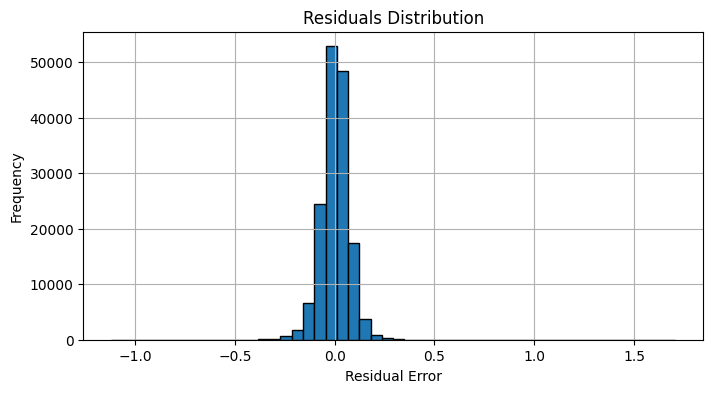

In [21]:
residuals = true_vals - pred_vals

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=50, edgecolor="black")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.grid(True)
plt.show()
